# Recurrent Neural Network - NER usecase ( Named Entity Recognition)

Task using an RNN to identify named entities in a text corpus. This task is known as named entity recognition (NER).

Understanding the data

We have defined a function called download_data(), which can be used to download the data. We won’t go into the details of it because it simply downloads several files and places them in a data folder. Once the download finishes, we’ll have three files:

data\conllpp_train.txt: A training set that contains 14041 sentences.

data\conllpp_dev.txt: A validation set that contains 3,250 sentences.

data\conllpp_test.txt: A test set that contains 3,452 sentences.

The document has a single word in each line, along with the associated tags of that word. These tags are in the following order:

1. The part-of-speech (POS) tag (e.g., noun is NN, verb is VB, determinant is DT, etc.)

2. The chunk tag: A chunk is a segment of text made of one or more tokens (for example, NP represents a noun phrase such as “The European Commission”)

3. Named entity tag (e.g., location, organization, person, etc.)

Both chunk tags and named entity tags have a B- and I- prefix (e.g., B-ORG or I-ORG). These prefixes are there to differentiate the starting token of an entity or chunk from the continuing token of an entity or chunk.

There are also five types of entities in the dataset:

a. Location-based entities (LOC)

b. Person-based entities (PER)

c. Organization-based entities (ORG)

d. Miscellaneous entities (MISC)

e. Nonentities (O)

# 1. Import Necessary Libraries

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import collections
import math
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve

seed = 54321

# 2. Downloading the data

In [2]:
url = 'https://github.com/ZihanWangKi/CrossWeigh/raw/master/data/'
dir_name = 'data'
#https://github.com/ZihanWangKi/CrossWeigh/raw/master/data/conllpp_train.txt
def download_data(url, filename, download_dir, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""

    # Create directories if they don't exist.
    os.makedirs(download_dir, exist_ok=True)

    # If file doesn't exist, download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)

    # Check the file size
    statinfo = os.stat(filepath)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filepath)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filepath + '. Can you get to it with a browser?')

    return filepath

# Filepaths to train/valid/test data
train_filepath = download_data(url, 'conllpp_train.txt', dir_name, 3283420)
dev_filepath = download_data(url, 'conllpp_dev.txt', dir_name, 827443)
test_filepath = download_data(url, 'conllpp_test.txt', dir_name, 748737)

Found and verified data/conllpp_train.txt
Found and verified data/conllpp_dev.txt
Found and verified data/conllpp_test.txt


# 3. Reading the data

###  load the data we downloaded into memory

In [3]:
def read_data(filename):
    '''
    Read data from a file with given file name
    Returns a list of sentences (each sentence a string)
    and list of ner labels for each string
    '''

    print("Reading data ...")
    # manager lists - Holds sentences (list of tokens), ner_labels (for each token an NER label)
    sentences, ner_labels = [], []

    # Open the file
    with open(filename,'r',encoding='latin-1') as f:
        # Read each line
        is_sos = True # We record at each line if we are seeing the beginning of a sentence

        # Tokens and labels of a single sentence, flushed when encountered a new one
        sentence_tokens = []
        sentence_labels = []
        i = 0
        for row in f:
            # If we are seeing an empty line or -DOCSTART- that's a new line
            if len(row.strip()) == 0 or row.split(' ')[0] == '-DOCSTART-':
                is_sos = False
            # Otherwise keep capturing tokens and labels
            else:
                is_sos = True
                token, _, _, ner_label = row.split(' ')
                sentence_tokens.append(token)
                sentence_labels.append(ner_label.strip())

            # When we reach the end or reach the beginning of next
            # add the data to the manager lists, flush the temporary one
            if not is_sos and len(sentence_tokens)>0:
                sentences.append(' '.join(sentence_tokens))
                ner_labels.append(sentence_labels)
                sentence_tokens, sentence_labels = [], []

    print('\tDone')
    return sentences, ner_labels

# Train data
train_sentences, train_labels = read_data(train_filepath)
# Validation data
valid_sentences, valid_labels = read_data(dev_filepath)
# Test data
test_sentences, test_labels = read_data(test_filepath)

# Print some stats
print(f"Train size: {len(train_labels)}")
print(f"Valid size: {len(valid_labels)}")
print(f"Test size: {len(test_labels)}")

# Print some data
print('\nSample data\n')
for v_sent, v_labels in zip(valid_sentences[:5], valid_labels[:5]):
    print(f"Sentence: {v_sent}")
    print(f"Labels: {v_labels}")
    print('\n')

Reading data ...
	Done
Reading data ...
	Done
Reading data ...
	Done
Train size: 14041
Valid size: 3250
Test size: 3452

Sample data

Sentence: CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
Labels: ['O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sentence: LONDON 1996-08-30
Labels: ['B-LOC', 'O']


Sentence: West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .
Labels: ['B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Sentence: Their stay on top , though , may be short-lived as title rivals Essex , Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire .
Labels: ['O', 'O', 'O', 'O', 'O', 'O', '

# 4. Checking the balance of labels

One of the unique characteristics of NER tasks is class imbalance. That is, not all classes will have a roughly equal number of samples. As we can probably guess, in a corpus, there are more non-named entities than named entities. This leads to a significant class imbalance among labels.

To analyze the data, we’ll first convert the NER labels into a pandas Series object. This can be done by simply calling the pd.Series() construct on train_labels, valid_labels, and test_labels.

In [4]:
from itertools import chain

# Print the value count for each label
print("Training data label counts")
print(pd.Series(chain(*train_labels)).value_counts())

print("\nValidation data label counts")
print(pd.Series(chain(*valid_labels)).value_counts())

print("\nTest data label counts")
print(pd.Series(chain(*test_labels)).value_counts())

Training data label counts
O         169578
B-LOC       7140
B-PER       6600
B-ORG       6321
I-PER       4528
I-ORG       3704
B-MISC      3438
I-LOC       1157
I-MISC      1155
Name: count, dtype: int64

Validation data label counts
O         42759
B-PER      1842
B-LOC      1837
B-ORG      1341
I-PER      1307
B-MISC      922
I-ORG       751
I-MISC      346
I-LOC       257
Name: count, dtype: int64

Test data label counts
O         38143
B-ORG      1714
B-LOC      1645
B-PER      1617
I-PER      1161
I-ORG       881
B-MISC      722
I-LOC       259
I-MISC      252
Name: count, dtype: int64


# 5. Analyzing the sequence length

 we’ll analyze the sequence length (i.e., number of tokens) of each sentence. We need this information later to pad our sentences to a fixed length.

 we create a pandas Series object, where each item has the length of a sentence after splitting each sentence into a list of tokens. Then, we will look at the 5% and 95% percentiles of those lengths.

 Observation is 95% of our sentences have 37 tokens or less.

In [5]:
pd.Series(train_sentences).str.split().str.len().describe(percentiles=[0.05, 0.95])

count    14041.000000
mean        14.501887
std         11.602756
min          1.000000
5%           2.000000
50%         10.000000
95%         37.000000
max        113.000000
dtype: float64

# 6. Padding/truncating sentences to create arrays

it’s time to process the data. We’ll keep the sentences in the same format, i.e., a list of strings where each string represents a sentence. This is because we’ll integrate text processing right into our model (as opposed to doing it externally). For labels, we have to make several changes. Remember, labels are a list of lists, where the inner lists represent labels for all the tokens in each sentence. Specifically, we’ll do the following:

Convert the class labels to class IDs.

Pad the sequences of labels to a specified maximum length.

Generate a mask that indicates the padded labels so that we can use this information to disregard the padded labels during model training.

In [6]:
def get_label_id_map(train_labels):
    # Get the unique list of labels
    unique_train_labels = pd.Series(chain(*train_labels)).unique()
    # Create a class label -> class ID mapping
    labels_map = dict(zip(unique_train_labels, np.arange(unique_train_labels.shape[0])))
    print(f"labels_map: {labels_map}")
    return labels_map

In [7]:
labels_map = get_label_id_map(train_labels)

labels_map: {'B-ORG': 0, 'O': 1, 'B-MISC': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-ORG': 6, 'I-MISC': 7, 'I-LOC': 8}


In [8]:
def get_padded_int_labels(labels, labels_map, max_seq_length, return_mask=True):

    # Convert string labels to integers
    int_labels = [[labels_map[x] for x in one_seq] for one_seq in labels]


    # Pad sequences
    if return_mask:
        # If we return mask, we first pad with a special value (-1) and
        # use that to create the mask and later replace -1 with 'O'
        padded_labels = np.array(
            tf.keras.preprocessing.sequence.pad_sequences(
                int_labels, maxlen=max_seq_length, padding='post', truncating='post', value=-1
            )
        )

        # mask filter
        mask_filter = (padded_labels != -1)
        # replace -1 with 'O' s ID
        padded_labels[~mask_filter] = labels_map['O']
        return padded_labels, mask_filter.astype('int')

    else:
        padded_labels = np.array(ner_pad_sequence_func(int_labels, value=labels_map['O']))
        return padded_labels

# 7. Defining hyperparameters

let’s define several hyperparameters needed for our RNN, as shown here:

a. max_seq_length: Denotes the maximum length for a sequence. We infer this from our training data during data exploration. It’s important to have a reasonable length for sequences because otherwise, memory can explode due to the unrolling of the RNN.

b. embedding_size: The dimensionality of token embeddings. Since we have a small corpus, a value < 100 will suffice.

c. rnn_hidden_size: The dimensionality of hidden layers in the RNN. Increasing the dimensionality of the hidden layer usually leads to better performance. However, note that increasing the size of the hidden layer causes all three sets of internal weights (that is, U, W, and V) to increase as well, resulting in a high computational footprint.

d. n_classes: Number of unique output classes present.

e. batch_size: The batch size for training data, validation data, and test data. A hgher batch size often leads to better results as we are seeing more data during each optimization step, but just like unrolling, this causes a higher memory requirement.

f. epochs: The number of epochs to train the model for.

In [9]:
# The maximum length of sequences
max_seq_length = 40

# Size of token embeddings
embedding_size = 64

# Number of hidden units in the RNN layer
rnn_hidden_size = 64

# Number of output nodes in the last layer
n_classes = 9

# Number of samples in a batch
batch_size = 64

# Number of epochs to train
epochs = 3

# 8. Processing the labels

In [10]:
max_seq_length = 40
# Convert string labels to integers for all train/validation/test data
# Pad train/validation/test data
padded_train_labels, train_mask = get_padded_int_labels(train_labels, labels_map, max_seq_length, return_mask=True)

padded_valid_labels, valid_mask = get_padded_int_labels(valid_labels, labels_map, max_seq_length, return_mask=True)

padded_test_labels, test_mask  = get_padded_int_labels(test_labels, labels_map, max_seq_length, return_mask=True)

# Print some labels IDs
print(padded_train_labels[:2])
print(train_mask[:2])

[[0 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]
 [3 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1]]
[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


# 9. Introduction to the TextVectorization layer

The text vectorization layer tokenizes the text and converts it into word IDs. Next, each token is fed as an input at each time step of the RNN. Finally, the RNN predicts a label for each token at every time step.
The TextVectorization layer can be thought of as a modernized tokenizer that can be plugged into the model. Here, we’ll play around just with the TextVectorization layer without the overhead of the complexity from the rest of the model.



In [11]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

K.clear_session()

toy_corpus = ["I went to the market on Sunday", "The Market was empty."]
toy_vectorization_layer = TextVectorization()

# Fit it on a corpus of data
toy_vectorization_layer.adapt(toy_corpus)

toy_vectorized_output = toy_vectorization_layer(toy_corpus)
toy_vocabulary = toy_vectorization_layer.get_vocabulary()

print("With default arguments\n")
print(f"Data: \n{toy_vectorized_output}")
print(f"Vocabulary: {toy_vocabulary}")
print('-'*50)

toy_vectorization_layer = TextVectorization(max_tokens=5)
toy_vectorization_layer.adapt(toy_corpus)

print("\nWith limited vocabulary\n")
print(f"Data: \n{toy_vectorization_layer(toy_corpus)}")
print(f"Vocabulary: {toy_vectorization_layer.get_vocabulary()}")
print('-'*50)

toy_vectorization_layer = TextVectorization(standardize=None)
toy_vectorization_layer.adapt(toy_corpus)

print("\nWith preprocessing disabled\n")
print(f"Data: \n{toy_vectorization_layer(toy_corpus)}")
print(f"Vocabulary: {toy_vectorization_layer.get_vocabulary()}")
print('-'*50)

toy_vectorization_layer = TextVectorization(output_sequence_length=4)
toy_vectorization_layer.adapt(toy_corpus)

print("\nWith a maximum sequence length\n")
print(f"Data: \n{toy_vectorization_layer(toy_corpus)}")
print(f"Vocabulary: {toy_vectorization_layer.get_vocabulary()}")
print('-'*50)

With default arguments

Data: 
[[ 9  4  6  2  3  8  7]
 [ 2  3  5 10  0  0  0]]
Vocabulary: ['', '[UNK]', 'the', 'market', 'went', 'was', 'to', 'sunday', 'on', 'i', 'empty']
--------------------------------------------------

With limited vocabulary

Data: 
[[1 4 1 2 3 1 1]
 [2 3 1 1 0 0 0]]
Vocabulary: ['', '[UNK]', 'the', 'market', 'went']
--------------------------------------------------

With preprocessing disabled

Data: 
[[12  2  4  5  7  6 10]
 [ 9 11  3  8  0  0  0]]
Vocabulary: ['', '[UNK]', 'went', 'was', 'to', 'the', 'on', 'market', 'empty.', 'The', 'Sunday', 'Market', 'I']
--------------------------------------------------

With a maximum sequence length

Data: 
[[ 9  4  6  2]
 [ 2  3  5 10]]
Vocabulary: ['', '[UNK]', 'the', 'market', 'went', 'was', 'to', 'sunday', 'on', 'i', 'empty']
--------------------------------------------------


# 10. Implementing a recurrent neural network

Our model will have an embedding layer, followed by a simple RNN layer, and finally, a dense prediction layer. One thing to note in the work we have done so far is that we haven’t yet defined a Tokenizer object. Although the Tokenizer has been an important part of our NLP pipeline to convert each token (or word) into an ID, there’s a big downside to using an external tokenizer. After training the model, if we forget to save the tokenizer along with the model, our machine learning model becomes useless: to combat this, during inference, we would need to map each word to the exact ID it was mapped to during training.

This is a significant risk the tokenizer poses. We’ll seek an alternative where we’ll integrate the tokenization mechanism right into our model so that we don’t need to worry about it later. The figure depicts the overall architecture of the model:

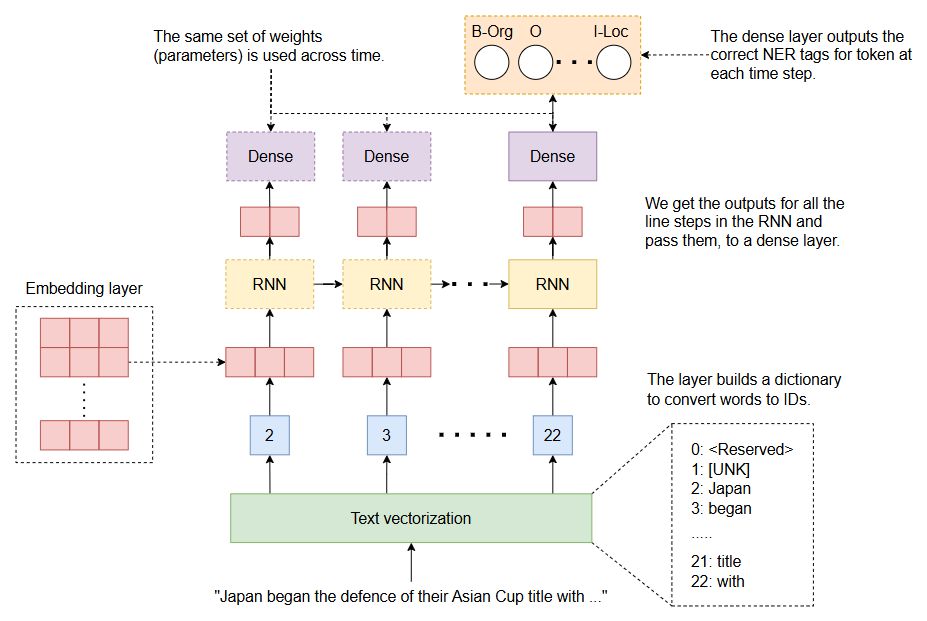

In [12]:
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


def get_fitted_token_vectorization_layer(corpus, max_seq_length, vocabulary_size=None):
    """ Fit a TextVectorization layer on given data """

    # Define a text vectorization layer
    vectorization_layer = TextVectorization(
        max_tokens=vocabulary_size, standardize=None,
        output_sequence_length=max_seq_length,
    )
    # Fit it on a corpus of data
    vectorization_layer.adapt(corpus)

    # Get the vocabulary size
    n_vocab = len(vectorization_layer.get_vocabulary())

    return vectorization_layer, n_vocab


# Input layer
word_input = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

# Text vectorize layer
vectorize_layer, n_vocab = get_fitted_token_vectorization_layer(train_sentences, max_seq_length)

# Vectorized output (each word mapped to an int ID)
vectorized_out = vectorize_layer(word_input)

# Look up embeddings for the returned IDs
embedding_layer = layers.Embedding(input_dim=n_vocab, output_dim=embedding_size, mask_zero=True)(vectorized_out)

# Define a simple RNN layer; it returns an output at each position
rnn_layer = layers.SimpleRNN(
    units=rnn_hidden_size, return_sequences=True
)

rnn_out = rnn_layer(embedding_layer)

dense_layer = layers.Dense(n_classes, activation='softmax')
dense_out = dense_layer(rnn_out)

model = tf.keras.Model(inputs=word_input, outputs=dense_out)

# 11. Defining a custom metric and compiling the model

During our previous discussion, we alluded to the fact that NER tasks carry a high class imbalance. It’s quite normal for text to have more nonentity-related tokens than entity-related tokens. This leads to large amounts of other (0) type labels and fewer of the remaining types. We need to take this into consideration when training the model and evaluating the model. We’ll address the class imbalance in two ways:

We’ll create a new evaluation metric that is resilient to class imbalance.

We’ll use sample weights to penalize more frequent classes and boost the importance of rare classes.

In this lesson, we’ll only address the former. The latter will be addressed in the next lesson. We’ll define a modified version of the accuracy. This is called a macro-averaged accuracy. In macro averaging, we compute accuracies for each class separately and then average it. Therefore, the class imbalance is ignored when computing the accuracy. When computing standard metrics like accuracy, precision, or recall, there are different types of averaging available.




In [13]:
def macro_accuracy(y_true, y_pred):

    # [batch size * time]
    y_true = tf.cast(tf.reshape(y_true, [-1]), 'int32')
    y_pred = tf.cast(tf.reshape(tf.argmax(y_pred, axis=-1), [-1]), 'int32')

    sorted_y_true = tf.sort(y_true)
    sorted_inds = tf.argsort(y_true)

    sorted_y_pred = tf.gather(y_pred, sorted_inds)

    sorted_correct = tf.cast(tf.math.equal(sorted_y_true, sorted_y_pred), 'int32')

    # We are adding one to make sure there is no division by zero.
    correct_for_each_label = tf.cast(tf.math.segment_sum(sorted_correct, sorted_y_true), 'float32') + 1
    all_for_each_label = tf.cast(tf.math.segment_sum(tf.ones_like(sorted_y_true), sorted_y_true), 'float32') + 1

    mean_accuracy = tf.reduce_mean(correct_for_each_label/all_for_each_label)

    return mean_accuracy

In [14]:
mean_accuracy_metric = tf.keras.metrics.MeanMetricWrapper(fn=macro_accuracy, name='macro_accuracy')

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[mean_accuracy_metric])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 40)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 40, 64)            1512000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 40, 64)            8256      
                                                                 
 dense (Dense)               (None, 40, 9)             585       
                                                                 
Total params: 1520841 (5.80 MB)
Trainable params: 1520841 (5.80 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

# 12. Training the model

Let’s train our model on the data we’ve prepared. But first, we need to define a function to tackle the class imbalance in our dataset. We’ll pass sample weights to the model.fit() function. To compute sample weights, we’ll first define a function called get_class_weights() that computes class_weights for each class.

The first function, get_class_weights(), takes a train_labels (a list of list of class IDs). Then, we create a pandas Series object with train_labels. Note that we’re using a function called chain from the built-in itertools library, which will flatten train_labels to a list of class IDs. The Series object contains frequency counts of each class label that appears in the train dataset. Next, to compute weights, we divide the minimum frequency element-wise from other frequencies. 

Finally, the output is converted into a dictionary that has class IDs as keys and class weights as values. Next, we need to convert the class_weights to sample_weights. We simply perform a dictionary lookup element-wise on each label to generate a sample weight from class_weights.




In [15]:
def get_class_weights(train_labels):

    label_count_ser = pd.Series(chain(*train_labels)).value_counts()
    label_count_ser = label_count_ser.sum()/label_count_ser
    label_count_ser /= label_count_ser.max()

    label_id_map = get_label_id_map(train_labels)
    label_count_ser.index = label_count_ser.index.map(label_id_map)
    return label_count_ser.to_dict()

def get_sample_weights_from_class_weights(labels, class_weights):
    """ From the class weights generate sample weights """
    return np.vectorize(class_weights.get)(labels)


train_class_weights = get_class_weights(train_labels)
print(f"Class weights: {train_class_weights}")

labels_map: {'B-ORG': 0, 'O': 1, 'B-MISC': 2, 'B-PER': 3, 'I-PER': 4, 'B-LOC': 5, 'I-ORG': 6, 'I-MISC': 7, 'I-LOC': 8}
Class weights: {1: 0.006811025015037328, 5: 0.16176470588235295, 3: 0.17500000000000002, 0: 0.18272425249169436, 4: 0.25507950530035334, 6: 0.31182505399568033, 2: 0.33595113438045376, 8: 0.9982713915298186, 7: 1.0}


In [16]:
# Make train_sequences an array
train_sentences = np.array(train_sentences)
train_sample_weights = get_sample_weights_from_class_weights(padded_train_labels, train_class_weights)

# Training the model
model.fit(train_sentences, padded_train_labels, sample_weight=train_sample_weights, batch_size=batch_size, epochs=epochs, validation_data=(np.array(valid_sentences), padded_valid_labels))

Epoch 1/3
220/220 [==============================] - 11s 38ms/step - loss: 0.0821 - macro_accuracy: 0.5741 - val_loss: 1.1559 - val_macro_accuracy: 0.7283
Epoch 2/3
220/220 [==============================] - 8s 34ms/step - loss: 0.0251 - macro_accuracy: 0.8925 - val_loss: 0.4630 - val_macro_accuracy: 0.8003
Epoch 3/3
220/220 [==============================] - 8s 36ms/step - loss: 0.0084 - macro_accuracy: 0.9601 - val_loss: 0.2756 - val_macro_accuracy: 0.8035


In [17]:
model.evaluate(np.array(test_sentences), padded_test_labels)

108/108 [==============================] - 1s 6ms/step - loss: 0.3915 - macro_accuracy: 0.7646


[0.3915115296840668, 0.7646195888519287]

# 13. Visually analyzing outputs



In [18]:
n_samples = 5
visual_test_sentences = test_sentences[:n_samples]
visual_test_labels = padded_test_labels[:n_samples]

visual_test_predictions = model.predict(np.array(visual_test_sentences))
visual_test_pred_labels = np.argmax(visual_test_predictions, axis=-1)

rev_labels_map = dict(zip(labels_map.values(), labels_map.keys()))
for i, (sentence, sent_labels, sent_preds) in enumerate(zip(visual_test_sentences, visual_test_labels, visual_test_pred_labels)):
    n_tokens = len(sentence.split())
    print("Sample:\t","\t".join(sentence.split()))
    print("True:\t","\t".join([rev_labels_map[i] for i in sent_labels[:n_tokens]]))
    print("Pred:\t","\t".join([rev_labels_map[i] for i in sent_preds[:n_tokens]]))
    print("\n")


1/1 [==============================] - 0s 397ms/step
Sample:	 SOCCER	-	JAPAN	GET	LUCKY	WIN	,	CHINA	IN	SURPRISE	DEFEAT	.
True:	 O	O	B-LOC	O	O	O	O	B-LOC	O	O	O	O
Pred:	 O	O	B-MISC	O	O	O	O	B-ORG	O	B-LOC	I-LOC	O


Sample:	 Nadim	Ladki
True:	 B-PER	I-PER
Pred:	 B-ORG	I-ORG


Sample:	 AL-AIN	,	United	Arab	Emirates	1996-12-06
True:	 B-LOC	O	B-LOC	I-LOC	I-LOC	O
Pred:	 B-ORG	O	B-LOC	I-LOC	I-LOC	I-ORG


Sample:	 Japan	began	the	defence	of	their	Asian	Cup	title	with	a	lucky	2-1	win	against	Syria	in	a	Group	C	championship	match	on	Friday	.
True:	 B-LOC	O	O	O	O	O	B-MISC	I-MISC	O	O	O	O	O	O	O	B-LOC	O	O	O	O	O	O	O	O	O
Pred:	 B-LOC	O	O	O	O	O	B-MISC	I-MISC	I-MISC	O	O	O	O	O	O	B-LOC	O	O	O	O	O	O	O	O	O


Sample:	 But	China	saw	their	luck	desert	them	in	the	second	match	of	the	group	,	crashing	to	a	surprise	2-0	defeat	to	newcomers	Uzbekistan	.
True:	 O	B-LOC	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	B-LOC	O
Pred:	 O	B-LOC	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O


